# Store Demand Forecasting

###### We have 5 years of store-item sales data, and we want to predict 3 months of sales for 50 different items at 10 different Amazon stores

## Importing Libraries

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

The code reads two CSV files, 'train.csv' and 'test.csv', and parses the 'date' column as dates during the reading process. It then concatenates the data from both files into a single DataFrame 'df', stacking them vertically. The 'head()' function is used to display the first few rows of the combined DataFrame

In [7]:
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])
df = pd.concat([train, test], sort=False)
df.head()

#df = train
#df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [8]:
df.drop(columns=['id'], inplace=True)

df.head()

,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-02,1,1,11.0
2,2013-01-03,1,1,14.0
3,2013-01-04,1,1,13.0
4,2013-01-05,1,1,10.0


#### Checking for null values

In [10]:
train.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

## Checking for Skewness

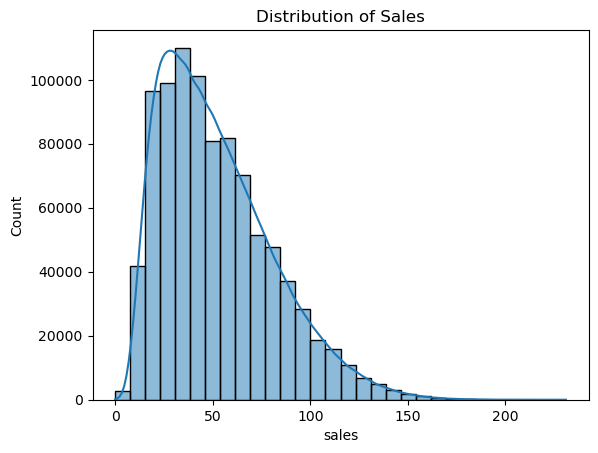

Skewness: nan


In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew


# Step 1: Visualize target variable distribution
sns.histplot(df['sales'], bins=30, kde=True)
plt.title('Distribution of Sales')
plt.show()

# Step 2: Check for skewness
skewness = skew(df['sales'])
print(f'Skewness: {skewness}')


In [13]:
df.shape

(958000, 4)

Calculating the quantiles (percentiles) of the data in the DataFrame 'df' for the specified quantile levels [0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]. It transposes the resulting DataFrame to display the quantiles for each column as rows.

In [15]:
df.quantile([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T

,0.00,0.05,0.25,0.50,0.75,0.95,0.99,1.00
date,2013-01-01 00:00:00,2013-04-06 00:00:00,2014-04-24 18:00:00,2015-08-16 12:00:00,2016-12-07 06:00:00,2017-12-26 00:00:00,2018-03-12 00:00:00,2018-03-31 00:00:00
store,1.0,1.0,3.0,5.5,8.0,10.0,10.0,10.0
item,1.0,3.0,13.0,25.5,38.0,48.0,50.0,50.0
sales,0.0,16.0,30.0,47.0,70.0,107.0,135.0,231.0


In [16]:
df["date"].min()

Timestamp('2013-01-01 00:00:00')

In [17]:
df["date"].max()

Timestamp('2018-03-31 00:00:00')

Descriptive statistics for the 'sales' column in the DataFrame 'df', including mean, standard deviation, minimum, maximum, and percentiles at the specified quantile levels [0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99]

In [19]:
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
10%          20.000000
30%          33.000000
50%          47.000000
70%          64.000000
80%          76.000000
90%          93.000000
95%         107.000000
99%         135.000000
max         231.000000
Name: sales, dtype: float64

In [20]:
df["store"].nunique()

10

In [21]:
df["item"].nunique()

50

We have 10 unique stores with 50 unique items

In [23]:
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

Grouping the DataFrame 'df' by both the "store" and "item" columns, and then aggregating the "sales" column for each group, calculating the sum, mean, median, and standard deviation of sales for each combination of store and item in the dataset.

In [25]:
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

## Feature Engineering

Here we extract various date-related features from the "date" column of the DataFrame 'df', such as month, day of the month, day of the year, week of the year, day of the week, and year. we also create new binary features indicating whether the date is a weekend, month start, or month end.

In [28]:
df['month'] = df.date.dt.month
df['day_of_month'] = df.date.dt.day
df['day_of_year'] = df.date.dt.dayofyear
df['week_of_year'] = df.date.dt.isocalendar().week  # Corrected
df['day_of_week'] = df.date.dt.dayofweek
df['year'] = df.date.dt.year
df['is_wknd'] = df.date.dt.weekday // 4
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
df['is_month_end'] = df.date.dt.is_month_end.astype(int)

In [29]:
df.head()

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,1,5,5,1,5,2013,1,0,0


In [30]:
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

### Random Noise

the random noise function adds variability to the dataset, making the model more robust, generalized, and capable of handling noisy, real-world data

In [32]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [33]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)
df.head()

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,1,5,5,1,5,2013,1,0,0


### Lag/Shifted Features

The lag_features function in this code adds lagged features to the DataFrame, which are typically used in time series analysis to capture the relationship between past values and current values.

This function transforms the DataFrame into one that includes lagged sales data (with random noise), which helps the model learn patterns over different time intervals while preventing overfitting.

In [35]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [36]:
df

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,3,27,86,13,1,2018,0,0,0,44.419118,53.528022,64.247022,70.765946,70.979863,80.492852,80.826350,60.123427,98.501749,72.599824
44996,2018-03-28,10,50,NaN,3,28,87,13,2,2018,0,0,0,64.512121,53.559339,69.051259,59.298668,74.240055,81.769428,78.512958,74.095205,80.730953,69.299064
44997,2018-03-29,10,50,NaN,3,29,88,13,3,2018,0,0,0,58.509990,58.594568,74.984331,63.363680,70.612878,86.247778,79.217197,69.139783,99.429750,76.453668
44998,2018-03-30,10,50,NaN,3,30,89,13,4,2018,1,0,0,73.502999,75.199345,74.786843,65.750131,65.348570,83.131551,89.564642,73.730730,74.954218,83.944931


### Rolling Mean Features

The roll_mean_features function helps to add rolling mean (moving average) features to our DataFrame. We use these features to smooth out short-term fluctuations in the data and highlight longer-term trends.

The roll_mean_features function generates rolling mean features (with added random noise) over specified window sizes. This helps capture trends and smooth fluctuations in the sales data, which can improve the performance of time series models by providing additional temporal context

In [38]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546, 730])

In [39]:
df

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730
0,2013-01-01,1,1,13.0,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,3,27,86,13,1,2018,0,0,0,44.419118,53.528022,64.247022,70.765946,70.979863,80.492852,80.826350,60.123427,98.501749,72.599824,89.065556,85.731471,81.743695
44996,2018-03-28,10,50,NaN,3,28,87,13,2,2018,0,0,0,64.512121,53.559339,69.051259,59.298668,74.240055,81.769428,78.512958,74.095205,80.730953,69.299064,86.465494,86.962293,82.990160
44997,2018-03-29,10,50,NaN,3,29,88,13,3,2018,0,0,0,58.509990,58.594568,74.984331,63.363680,70.612878,86.247778,79.217197,69.139783,99.429750,76.453668,85.511471,87.646433,80.800093
44998,2018-03-30,10,50,NaN,3,30,89,13,4,2018,1,0,0,73.502999,75.199345,74.786843,65.750131,65.348570,83.131551,89.564642,73.730730,74.954218,83.944931,85.022131,86.791059,83.497484


### Exponentially Weighted Mean Features

The ewm_features function adds Exponentially Weighted Moving Average (EWMA) features to a DataFrame. The EWMAs helps to give more weight to recent observations and less weight to older ones.

This function generates several EWMA features based on different smoothing factors and lag periods. This allows the model to better understand temporal patterns

In [41]:
#def ewm_features(dataframe, alphas, lags):
 #   for alpha in alphas:
  #      for lag in lags:
   #         dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
    #            dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    #return dataframe


#alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
#lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

#df = ewm_features(df, alphas, lags)
#df.tail()

### One-hot encoding 

we use one-hot encoding to convert Categorical variables('day_of_week' and 'month') to numerical format for modelling

In [43]:
df = pd.get_dummies(df, columns=['day_of_week', 'month'])

In [44]:
df.tail()

,date,store,item,sales,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
44995,2018-03-27,10,50,NaN,27,86,13,2018,0,0,0,44.419118,53.528022,64.247022,70.765946,70.979863,80.492852,80.826350,60.123427,98.501749,72.599824,89.065556,85.731471,81.743695,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
44996,2018-03-28,10,50,NaN,28,87,13,2018,0,0,0,64.512121,53.559339,69.051259,59.298668,74.240055,81.769428,78.512958,74.095205,80.730953,69.299064,86.465494,86.962293,82.990160,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
44997,2018-03-29,10,50,NaN,29,88,13,2018,0,0,0,58.509990,58.594568,74.984331,63.363680,70.612878,86.247778,79.217197,69.139783,99.429750,76.453668,85.511471,87.646433,80.800093,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
44998,2018-03-30,10,50,NaN,30,89,13,2018,1,0,0,73.502999,75.199345,74.786843,65.750131,65.348570,83.131551,89.564642,73.730730,74.954218,83.944931,85.022131,86.791059,83.497484,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False
44999,2018-03-31,10,50,NaN,31,90,13,2018,1,0,1,62.674731,69.262913,52.008996,68.123969,48.547737,78.401473,101.386723,100.423057,98.647675,81.981866,85.644415,87.739596,81.230975,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False


Applying the natural logarithm transformation (logarithm with base e) to the 'sales' column in the DataFrame 'df', using the numpy function 'np.log1p', which handles zero values gracefully by adding 1 before taking the logarithm. This transformation is often used to stabilize the variance and improve the performance of certain models

In [46]:
df.head()

,date,store,item,sales,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,1,1,13.0,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,2013-01-02,1,1,11.0,2,2,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,2013-01-03,1,1,14.0,3,3,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,2013-01-04,1,1,13.0,4,4,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,2013-01-05,1,1,10.0,5,5,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False


The presence of NaN values in some rows of the lag features are excpected when we use the shift() function. This happens because the shift() operation introduces missing values for the first ag rows where data doesn't exist for the required shift.



In [48]:
df.head()

,date,store,item,sales,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,1,1,13.0,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,2013-01-02,1,1,11.0,2,2,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,2013-01-03,1,1,14.0,3,3,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,2013-01-04,1,1,13.0,4,4,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,2013-01-05,1,1,10.0,5,5,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False


### Log Transformation for Sales

In [50]:
df['sales'] = np.log1p(df["sales"].values)

In [51]:
df.head()

,date,store,item,sales,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,1,1,2.639057,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,2013-01-02,1,1,2.484907,2,2,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,2013-01-03,1,1,2.708050,3,3,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,2013-01-04,1,1,2.639057,4,4,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,2013-01-05,1,1,2.397895,5,5,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False


In [52]:
df.to_csv('Cleaned_df.csv')

Our Dataset is ready for Modelling

## Modeling

This code creates two new DataFrames, 'train' and 'val', by filtering rows from the original DataFrame 'df' based on the dates. 'train' contains data before January 1, 2017, and 'val' contains data between January 1, 2017, and April 1, 2017. The variable 'cols' is defined as a list of column names from 'train' DataFrame, excluding the columns 'date', 'id', 'sales', and 'year'
The code creates two new DataFrames, 'train' and 'val', by filtering rows from the original DataFrame 'df' based on the dates. 'train' contains data before January 1, 2017, and 'val' contains data between January 1, 2017, and April 1, 2017. The variable 'cols' is defined as a list of column names from 'train' DataFrame, excluding the columns 'date', 'id', 'sales', and 'year'

In [55]:
train = df.loc[(df["date"] < "2017-01-01"), :]

val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', "sales", "year"]]

In [56]:
cols

['store',
 'item',
 'day_of_month',
 'day_of_year',
 'week_of_year',
 'is_wknd',
 'is_month_start',
 'is_month_end',
 'sales_lag_91',
 'sales_lag_98',
 'sales_lag_105',
 'sales_lag_112',
 'sales_lag_119',
 'sales_lag_126',
 'sales_lag_182',
 'sales_lag_364',
 'sales_lag_546',
 'sales_lag_728',
 'sales_roll_mean_365',
 'sales_roll_mean_546',
 'sales_roll_mean_730',
 'day_of_week_0',
 'day_of_week_1',
 'day_of_week_2',
 'day_of_week_3',
 'day_of_week_4',
 'day_of_week_5',
 'day_of_week_6',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12']

In [57]:
Y_train = train['sales']

X_train = train[cols]

Y_val = val['sales']

X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 40), (45000,), (45000, 40))

## Custom Cost Function

The code defines two functions: 'smape' calculates the Symmetric Mean Absolute Percentage Error (SMAPE) for two arrays of predictions and true target values, while 'lgbm_smape' computes SMAPE for LightGBM predictions by converting them back from log-scale using 'np.expm1' and comparing with the original labels.

In [59]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

Here we define the training process for a LightGBM model, utilizing training and validation datasets to ensure accurate predictions. It applies early stopping to prevent overfitting if the model stops improving after a set number of rounds. The training progress is logged every 100 iterations for monitoring. After training, the model is evaluated using the SMAPE (Symmetric Mean Absolute Percentage Error) on the validation set to measure prediction accuracy. This ensures a robust model with optimized performance based on validation data, improving generalization.

In [61]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 2000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [62]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

# Train the model with callbacks for early stopping and logging
model = lgb.train(
    lgb_params,
    lgbtrain,
    valid_sets=[lgbtrain, lgbval],
    num_boost_round=lgb_params['num_boost_round'],
    feval=lgbm_smape,
    callbacks=[
        lgb.early_stopping(stopping_rounds=lgb_params['early_stopping_rounds']),
        lgb.log_evaluation(100)  # Log evaluation every 100 iterations
    ]
)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
smape(np.expm1(y_pred_val), np.expm1(Y_val))


Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.174002	training's SMAPE: 17.7432	valid_1's l1: 0.176711	valid_1's SMAPE: 18.0491
[200]	training's l1: 0.143637	training's SMAPE: 14.7084	valid_1's l1: 0.147991	valid_1's SMAPE: 15.1758
[300]	training's l1: 0.137797	training's SMAPE: 14.1234	valid_1's l1: 0.143234	valid_1's SMAPE: 14.6988
[400]	training's l1: 0.13538	training's SMAPE: 13.8813	valid_1's l1: 0.141121	valid_1's SMAPE: 14.4869
[500]	training's l1: 0.133839	training's SMAPE: 13.7264	valid_1's l1: 0.1394	valid_1's SMAPE: 14.3139
[600]	training's l1: 0.132745	training's SMAPE: 13.6167	valid_1's l1: 0.138046	valid_1's SMAPE: 14.1778
[700]	training's l1: 0.131932	training's SMAPE: 13.535	valid_1's l1: 0.136973	valid_1's SMAPE: 14.0698
[800]	training's l1: 0.131313	training's SMAPE: 13.4728	valid_1's l1: 0.136088	valid_1's SMAPE: 13.9807
[900]	training's l1: 0.130797	training's SMAPE: 13.421	valid_1's l1: 0.135406	valid_1's SMAPE: 13.9119
[1000]	

13.646614406776163

In [63]:
model.best_iteration

2000

Here we prepare the final LightGBM model for predicting sales. We separate the dataset into training and testing sets, where train excludes missing sales values and test includes them. The parameters for LightGBM are defined, focusing on metrics and model complexity. The model is trained on the entire training dataset (lgbtrain_all), and predictions are made on the test dataset (X_test). This final model is crucial for generating sales forecasts based on learned patterns from the training data.

In [65]:
#Final Model

train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

In [66]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": 1000} #model.best_iteration}


#num_boost_round = 1000

# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

#model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=num_boost_round)
model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=lgb_params["num_boost_round"])

test_preds = model.predict(X_test, num_iteration=model.best_iteration)

In [67]:
test_preds

array([2.61975221, 2.67482084, 2.67721355, ..., 4.36627505, 4.46224517,
       4.50927197])

Here, we create a DataFrame named forecast to store the predicted sales for a specific store and item combination from the test dataset. It filters the DataFrame for sales forecasts for Store 1, Item 1, and plots these forecasts against the date. The graph is visualized in green, with a specified size of 20x9 inches. This visualization helps assess the model's performance in predicting future sales, making it easier to analyze trends over time.

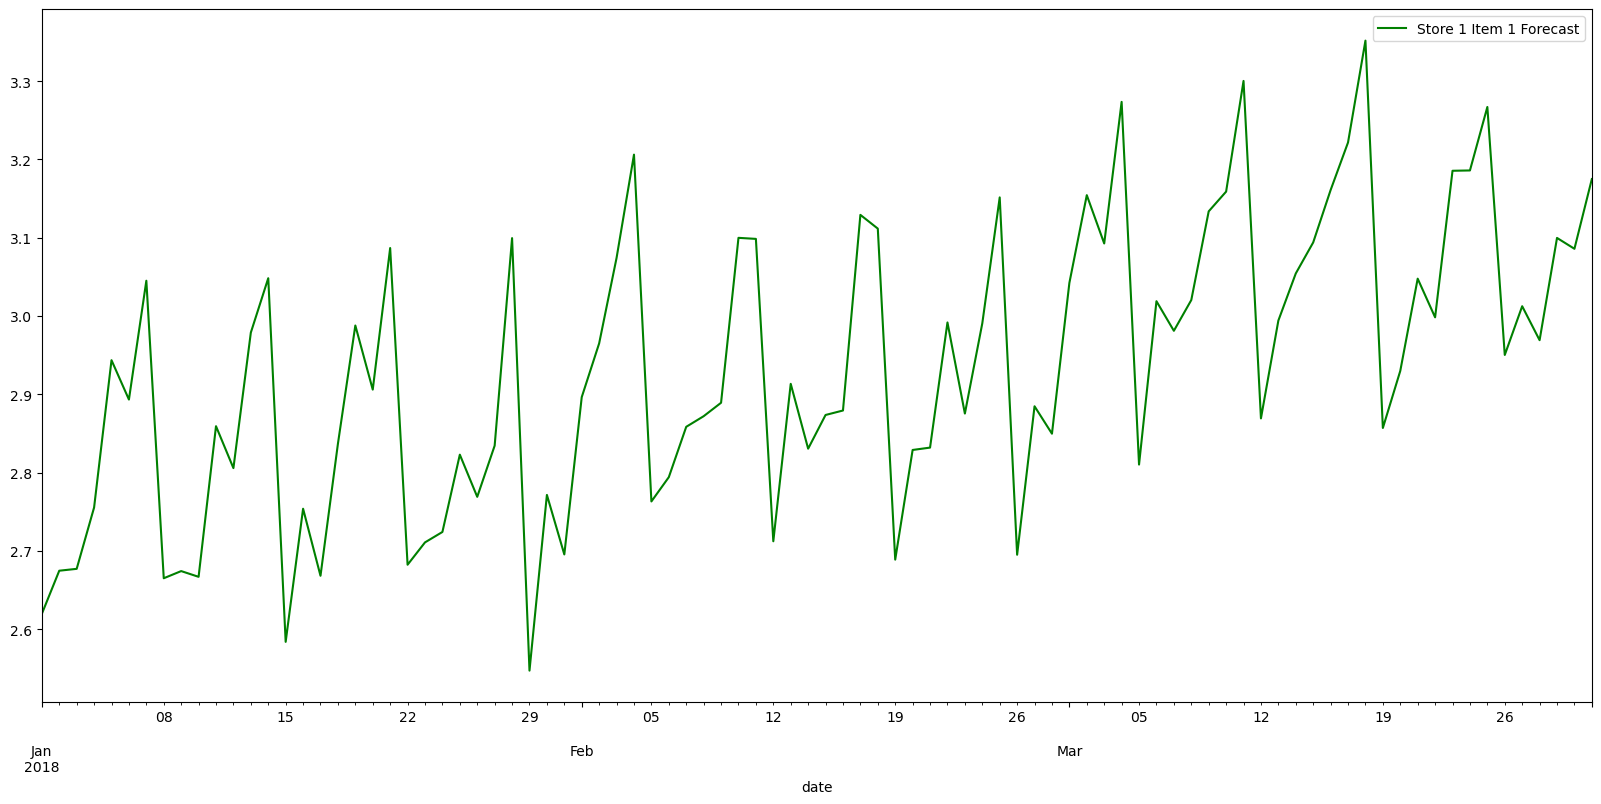

In [69]:
forecast = pd.DataFrame({"date":test["date"],
                        "store":test["store"],
                        "item":test["item"],
                        "sales":test_preds
                        })

forecast[(forecast.store == 1) & (forecast.item == 1)].set_index("date").sales.plot(color = "green",
                                                                                    figsize = (20,9),
                                                                                    legend=True, label = "Store 1 Item 1 Forecast");

Here we visualize the actual sales data and the forecasted sales for Store 1, Item 17. The first line filters the training dataset to plot the actual sales against the date, while the second line filters the forecast DataFrame for the predicted sales of the same store and item combination. Both plots are displayed on the same graph, allowing for a direct comparison between actual and predicted sales over time. This comparison is crucial for evaluating the model's accuracy in predicting sales trends.

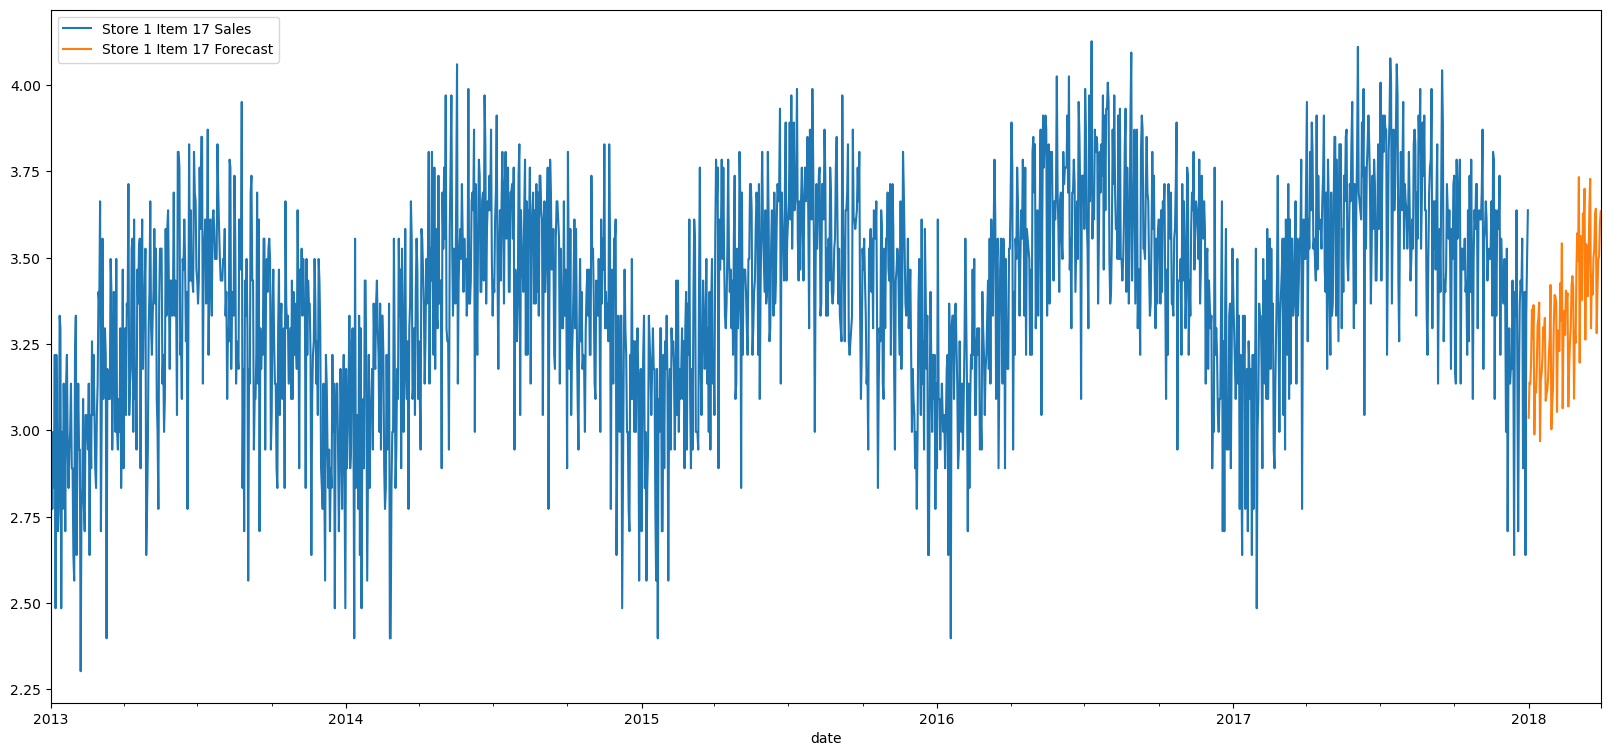

In [71]:
train[(train.store == 1) & (train.item == 17)].set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Store 1 Item 17 Sales")
forecast[(forecast.store == 1) & (forecast.item == 17)].set_index("date").sales.plot(legend=True, label = "Store 1 Item 17 Forecast");